In [32]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [33]:
import sys
from PIL import Image

from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
from glob import glob
import numpy as np
import torch
from random import shuffle
import random
from numpy import random as npr
import pandas as pd
import imageio
from PIL import Image


class MethaneLoader(DataLoader):

    def __init__(self, device, mode, plume_id, red=False, alli=False, channels=12):
        self.device = device
        self.mode = mode
        self.reduce = red
        self.channels = channels

        if mode == "train":
            persist = False
        else:
            persist = True
        
        if plume_id is not None:
            self.pos_labels = sorted(
                glob("/kaggle/input/ch4net-dataset/data/{}/label/*/{}.npy".format(mode, plume_id)))
#             self.neg_labels = sorted(
#                 glob("/kaggle/input/ch4net-dataset/data/{}/label/pos/{}.npy".format(mode, plume_id)))
            self.neg_labels = []
        else:
            self.pos_labels = sorted(
                glob("/kaggle/input/ch4net-dataset/data/{}/label/pos/*.npy".format(mode)))
            self.neg_labels = sorted(
                glob("/kaggle/input/ch4net-dataset/data/{}/label/neg/*.npy".format(mode)))

        self.labels = self.pos_labels+self.neg_labels  # None
        
        if not alli:
            self.sample_labels_and_combine(persist=persist)

    def sample_labels_and_combine(self, persist=False):
        """
        Sample a subset of negative labels for each epoch
        """
        # if self.mode == "test":
        if self.mode in ["test", "val"]:
            self.labels = self.pos_labels+self.neg_labels
        else:
            if persist:
                random.seed(555)

            shuffle(self.neg_labels)
            self.labels = self.pos_labels + \
                self.neg_labels[:len(self.pos_labels)]

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, index):

        f = self.labels[index]
        # print(f)

        plume_id = int(f.split("/")[-1].split(".")[0])
        # print(plume_id)

        target = np.load(f)
        context = np.load(
            "/kaggle/input/ch4net-dataset/data/{}/s2/{}.npy".format(self.mode, plume_id))

        if self.channels == 2:
            context = context[..., 10:]
        if self.channels == 5:
            context = np.concatenate(
                [context[..., 1:4], context[..., 10:]], axis=-1)
        
        if self.mode == "train":
            # rotate by 90, 180, 270 degrees
            degrees = npr.choice([0, 90, 180, 270])
            context = np.rot90(context, k=degrees//90)
            target = np.rot90(target, k=degrees//90)
            if npr.rand() > 0.5:
                context = np.flip(context, axis=0)
                target = np.flip(target, axis=0)
            if npr.rand() > 0.5:
                context = np.flip(context, axis=1)
                target = np.flip(target, axis=1)

        # Crop to centre
        # x_c = target.shape[0]//2
        # y_c = target.shape[1]//2
        s = 64

        if self.mode == "train":
            rng = npr.RandomState()
            mid_loc_x = rng.randint(s, target.shape[0]-s)
            mid_loc_y = rng.randint(s, target.shape[1]-s)

        else:
            mid_loc_x = target.shape[0]//2
            mid_loc_y = target.shape[1]//2

        target = target[mid_loc_x-s:mid_loc_x+s,
                        mid_loc_y-s: mid_loc_y+s]

        context = context[mid_loc_x-s:mid_loc_x+s,
                          mid_loc_y-s: mid_loc_y+s, :]

        ### These are not defined before and not necessary for training. 
        ### But these are used in evaluation outputs
#         diff_img = np.array(diff_img[mid_loc_x-s:mid_loc_x+s,
#                                      mid_loc_y-s:mid_loc_y+s, :])
#         diff_img_g = np.array(diff_img_g[mid_loc_x-s:mid_loc_x+s,
#                                          mid_loc_y-s:mid_loc_y+s])
#         rgb_img = np.array(rgb_img[mid_loc_x-s:mid_loc_x+s,
#                                    mid_loc_y-s:mid_loc_y+s, :])

        if self.reduce:
            target = np.array([np.int(target.any())])

        # if self.mode == "test":
            # print("Plume ID: {}, date: {}".format(plume_id, date))

        d = {"pred": torch.from_numpy(context.copy()).float().to(self.device).permute(2, 0, 1)/255,
             "target": torch.from_numpy(target.copy()).float().to(self.device)}
        
        # Print the size of the image tensor
#         print("Image tensor size (context):", d["pred"].size())
#         print("Image tensor size (target):", d["target"].size())

        return d

In [34]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class MLP(nn.Module):
    """
    Base MLP module with ReLU activation
    Parameters:
    -----------
    in_channels: Int
        Number of input channels
    out_channels: Int
        Number of output channels
    h_channels: Int
        Number of hidden channels
    h_layers: Int
        Number of hidden layers
    """

    def __init__(self, 
                in_channels, 
                out_channels, 
                h_channels=64,
                h_layers=4):

        super().__init__()

        def hidden_block(h_channels):
            h = nn.Sequential(
            nn.Linear(h_channels, h_channels),
            nn.ReLU())
            return h

        # Model
        
        self.mlp = nn.Sequential(
            nn.Linear(in_channels, h_channels),
            nn.ReLU(),
            *[hidden_block(h_channels) for _ in range(h_layers)],
            nn.Linear(h_channels, out_channels) 
        )

    def forward(self, x):
        return self.mlp(x)

class Unet(nn.Module):
    def __init__(self,
                 in_channels,
                 out_channels,
                 div_factor=8,
                 prob_output=True,
                 class_output=False

    ):
        super(Unet, self).__init__()

        self.n_channels = in_channels
        self.bilinear = True
        self.sigmoid = nn.Sigmoid()
        self.prob_output = prob_output
        self.class_output = class_output

        def double_conv(in_channels, out_channels):
            return nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
                nn.BatchNorm2d(out_channels),
                nn.ReLU(inplace=True),
                nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
                nn.BatchNorm2d(out_channels),
                nn.ReLU(inplace=True),
            )

        def down(in_channels, out_channels):
            return nn.Sequential(
                nn.MaxPool2d(2),
                double_conv(in_channels, out_channels)
            )

        class up(nn.Module):
            def __init__(self, in_channels, out_channels, bilinear=True):
                super().__init__()

                if bilinear:
                    self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
                else:
                    self.up = nn.ConvTranpose2d(in_channels // 2, in_channels // 2,
                                                kernel_size=2, stride=2)

                self.conv = double_conv(in_channels, out_channels)

            def forward(self, x1, x2):
                x1 = self.up(x1)
                # [?, C, H, W]
                diffY = x2.size()[2] - x1.size()[2]
                diffX = x2.size()[3] - x1.size()[3]

                x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                                diffY // 2, diffY - diffY // 2])
                x = torch.cat([x2, x1], dim=1) ## why 1?
                return self.conv(x)

        self.inc = double_conv(self.n_channels, 64//div_factor)
        self.down1 = down(64//div_factor, 128//div_factor)
        self.down2 = down(128//div_factor, 256//div_factor)
        self.down3 = down(256//div_factor, 512//div_factor)
        self.down4 = down(512//div_factor, 512//div_factor)
        self.up1 = up(1024//div_factor, 256//div_factor)
        self.up2 = up(512//div_factor, 128//div_factor)
        self.up3 = up(256//div_factor, 64//div_factor)
        self.up4 = up(128//div_factor, 128//div_factor)
        self.out = nn.Conv2d(128//div_factor, 1, kernel_size=1)


    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)

        #return self.out(x).permute(0,2,3,1)

        if self.prob_output:
            x = self.out(x)
            return self.sigmoid(x).permute(0,2,3,1)
        else:
            return self.out(x).permute(0,2,3,1)

In [35]:
import torch
import torch.nn as nn

class conv_block(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(conv_block, self).__init__()

        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, kernel_size=3, stride=1, padding=1, bias=True),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, kernel_size=3, stride=1, padding=1, bias=True),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True))

    def forward(self, x):
        x = self.conv(x)
        return x

class up_conv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(up_conv, self).__init__()
        self.up = nn.Sequential(
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),
            nn.Conv2d(in_ch, out_ch, kernel_size=3, stride=1, padding=1, bias=True),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        x = self.up(x)
        return x

class Attention_block(nn.Module):
    def __init__(self, F_g, F_l, F_int):
        super(Attention_block, self).__init__()

        self.W_g = nn.Sequential(
            nn.Conv2d(F_l, F_int, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(F_int)
        )

        self.W_x = nn.Sequential(
            nn.Conv2d(F_g, F_int, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(F_int)
        )

        self.psi = nn.Sequential(
            nn.Conv2d(F_int, 1, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(1),
            nn.Sigmoid()
        )

        self.relu = nn.ReLU(inplace=True)

    def forward(self, g, x):
        g1 = self.W_g(g)
        x1 = self.W_x(x)
        psi = self.relu(g1 + x1)
        psi = self.psi(psi)
        out = x * psi
        return out

class UNet_Attention(nn.Module):
    def __init__(self, img_ch=12, output_ch=1):
        super(UNet_Attention, self).__init__()

        n1 = 64
        filters = [n1, n1 * 2, n1 * 4, n1 * 8, n1 * 16]

        self.Maxpool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.Maxpool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.Maxpool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.Maxpool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.Conv1 = conv_block(img_ch, filters[0])
        self.Conv2 = conv_block(filters[0], filters[1])
        self.Conv3 = conv_block(filters[1], filters[2])
        self.Conv4 = conv_block(filters[2], filters[3])
        self.Conv5 = conv_block(filters[3], filters[4])

        self.Up5 = up_conv(filters[4], filters[3])
        self.Att5 = Attention_block(F_g=filters[3], F_l=filters[3], F_int=filters[2])
        self.Up_conv5 = conv_block(filters[4], filters[3])

        self.Up4 = up_conv(filters[3], filters[2])
        self.Att4 = Attention_block(F_g=filters[2], F_l=filters[2], F_int=filters[1])
        self.Up_conv4 = conv_block(filters[3], filters[2])

        self.Up3 = up_conv(filters[2], filters[1])
        self.Att3 = Attention_block(F_g=filters[1], F_l=filters[1], F_int=filters[0])
        self.Up_conv3 = conv_block(filters[2], filters[1])

        self.Up2 = up_conv(filters[1], filters[0])
        self.Att2 = Attention_block(F_g=filters[0], F_l=filters[0], F_int=32)
        self.Up_conv2 = conv_block(filters[1], filters[0])

        self.Conv = nn.Conv2d(filters[0], output_ch, kernel_size=1, stride=1, padding=0)


    def forward(self, x):

        e1 = self.Conv1(x)

        e2 = self.Maxpool1(e1)
        e2 = self.Conv2(e2)

        e3 = self.Maxpool2(e2)
        e3 = self.Conv3(e3)

        e4 = self.Maxpool3(e3)
        e4 = self.Conv4(e4)

        e5 = self.Maxpool4(e4)
        e5 = self.Conv5(e5)

        d5 = self.Up5(e5)

        x4 = self.Att5(g=d5, x=e4)
        d5 = torch.cat((x4, d5), dim=1)
        d5 = self.Up_conv5(d5)

        d4 = self.Up4(d5)
        x3 = self.Att4(g=d4, x=e3)
        d4 = torch.cat((x3, d4), dim=1)
        d4 = self.Up_conv4(d4)

        d3 = self.Up3(d4)
        x2 = self.Att3(g=d3, x=e2)
        d3 = torch.cat((x2, d3), dim=1)
        d3 = self.Up_conv3(d3)

        d2 = self.Up2(d3)
        x1 = self.Att2(g=d2, x=e1)
        d2 = torch.cat((x1, d2), dim=1)
        d2 = self.Up_conv2(d2)

        out = self.Conv(d2)

        return out

# Example usage:

# Instantiate the model
model = UNet_Attention(img_ch=12, output_ch=1)

# Example input tensor with shape [batch_size, channels, height, width]
input_tensor = torch.randn(16, 12, 128, 128)  # Example batch size of 16

# Example target tensor with shape [batch_size, height, width]
target_tensor = torch.randn(16, 128, 128)

# Adjust the target tensor to match the output shape
target_tensor = target_tensor.unsqueeze(1)

# Forward pass
output = model(input_tensor)

# Check output shape
print(f"Output shape: {output.shape}")  # Should be [16, 1, 128, 128]
print(f"Target shape: {target_tensor.shape}")  # Should be [16, 1, 128, 128]


Output shape: torch.Size([16, 1, 128, 128])
Target shape: torch.Size([16, 1, 128, 128])


In [36]:
from matplotlib import pyplot as plt
import torch
import scipy
import numpy as np
from tqdm import tqdm
from torch import autograd
from torch.utils.data import DataLoader
# from loader import *


class Trainer():
    """
    Training class for the neural process models
    """

    def __init__(self,
                 model,
                 train_loader,
                 val_loader,
                 train_dataset,
                 loss_function,
                 save_path,
                 learning_rate):

        # Model and data
        self.model = model
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.train_dataset = train_dataset
        self.save_path = save_path

        # Training parameters
        self.opt = torch.optim.Adam(model.parameters(), lr=learning_rate)
        self.loss_function = loss_function
        self.sched = torch.optim.lr_scheduler.ReduceLROnPlateau(self.opt, mode='min', factor=0.5, patience=5, verbose=True)

        # Losses
        self.losses = []

    def plot_losses(self):
        """
        Plot losses for the trained model
        """
        plt.plot(np.array(self.losses))
        plt.xlabel("epoch")
        plt.ylabel("NLL")
        plt.show()

    def _unravel_to_numpy(self, x):
        return x.view(-1).detach().cpu().numpy()

    def eval_epoch(self, verbose=False):

        self.model.eval()
        lf = []

        outs = []
        ts = []

        with torch.no_grad():
            for task in self.val_loader:

                out = self.model(task["pred"])
                lf.append(self.loss_function(np.squeeze(out), task["target"]))
                outs.append(out.detach().cpu().numpy())
                ts.append(task["target"].detach().cpu().numpy())

        # Get loss function
        log_loss = torch.mean(torch.tensor(lf))
        print("- Log loss: {}".format(log_loss))
    
        if verbose:
            return log_loss, np.concatenate(outs, axis=0), np.concatenate(ts, axis=0)

        return log_loss

    def train(self, n_epochs=100):

        # Init progress bar
        best_loss = 100000
        best_model_state_dict = None
        best_opt_state_dict = None
        i = 1

        for epoch in range(n_epochs):

            autograd.set_detect_anomaly(True)

            print("Training epoch {}".format(epoch))

            if epoch < 500:
                self.model.train()
                self.train_dataset.sample_labels_and_combine()
                self.train_loader = DataLoader(self.train_dataset,
                                               batch_size=16,
                                               shuffle=True)

            with tqdm(self.train_loader, unit="batch") as tepoch:
                for task in tepoch:
                    
                    out = self.model(task["pred"])
                    
                    # print("loss")
                    loss = self.loss_function(np.squeeze(out), task["target"])

                    loss.backward()
                    self.opt.step()
                    self.opt.zero_grad()
                    # print("out")
                    tepoch.set_postfix(loss=loss.item())
                epoch_loss = self.eval_epoch(verbose=False)
                self.sched.step(epoch_loss)
            
            if np.logical_or(epoch_loss <= best_loss, epoch >= 1000):
#                 torch.save({
#                     'epoch': epoch,
#                     'model_state_dict': self.model.state_dict(),
#                     'optimizer_state_dict': self.opt.state_dict(),
#                     'loss': epoch_loss
#                 }, self.save_path+"epoch_{}".format(epoch))
                best_model_state_dict = self.model.state_dict()
                best_opt_state_dict = self.opt.state_dict()
                best_loss = epoch_loss
#                 np.save("outs.npy", o)
#                 np.save("ts.npy", t)

            self.losses.append(epoch_loss)
    
            ## checkpoint
            if i % 20 == 0 or i == n_epochs: 
                np.save(self.save_path+"losses.npy", np.array(self.losses))
                self.plot_losses()

                torch.save({
                    # 'epoch': epoch,
                    'model_state_dict': best_model_state_dict,
                    'optimizer_state_dict': best_opt_state_dict,
                    'loss': best_loss
                }, self.save_path+"final_model".format(epoch))
            i += 1

        print("Training complete!")

In [37]:
!mkdir -p /kaggle/working/train_out
!mkdir -p /kaggle/working/eval_out

In [38]:
from torchvision.ops import sigmoid_focal_loss

def loss(pred, target):
#     print(pred.shape, target.shape)
    bce_loss = nn.BCEWithLogitsLoss(reduction="none") 
    ll = bce_loss(pred, target)

    ll = ll.sum(dim=(-2,-1)) #*mask
    return ll.mean()

def focal_loss(pred, target, alpha=0.75, gamma=2.0, reduction='none'):
    loss = sigmoid_focal_loss(pred, target, alpha=alpha, gamma=gamma, reduction=reduction)
    loss = loss.sum(dim=(-2,-1))
    return loss.mean()

Training epoch 0


100%|██████████| 75/75 [00:14<00:00,  5.16batch/s, loss=3.53e+3]


- Log loss: 3038.48828125
Training epoch 1


100%|██████████| 75/75 [00:14<00:00,  5.16batch/s, loss=2.59e+3]


- Log loss: 2342.10693359375
Training epoch 2


100%|██████████| 75/75 [00:14<00:00,  5.30batch/s, loss=2.36e+3]


- Log loss: 2012.0303955078125
Training epoch 3


100%|██████████| 75/75 [00:14<00:00,  5.28batch/s, loss=2.25e+3]


- Log loss: 1503.2554931640625
Training epoch 4


100%|██████████| 75/75 [00:14<00:00,  5.26batch/s, loss=1.9e+3] 


- Log loss: 1394.754638671875
Training epoch 5


100%|██████████| 75/75 [00:14<00:00,  5.27batch/s, loss=1.49e+3]


- Log loss: 1246.4312744140625
Training epoch 6


100%|██████████| 75/75 [00:14<00:00,  5.04batch/s, loss=1.99e+3]


- Log loss: 1063.540283203125
Training epoch 7


100%|██████████| 75/75 [00:14<00:00,  5.16batch/s, loss=1.45e+3]


- Log loss: 962.9119873046875
Training epoch 8


100%|██████████| 75/75 [00:14<00:00,  5.09batch/s, loss=1.39e+3]


- Log loss: 922.230224609375
Training epoch 9


100%|██████████| 75/75 [00:14<00:00,  5.27batch/s, loss=1.29e+3]


- Log loss: 932.82275390625
Training epoch 10


100%|██████████| 75/75 [00:14<00:00,  5.26batch/s, loss=1.4e+3] 


- Log loss: 911.740234375
Training epoch 11


100%|██████████| 75/75 [00:14<00:00,  5.32batch/s, loss=1.88e+3]


- Log loss: 788.1045532226562
Training epoch 12


100%|██████████| 75/75 [00:14<00:00,  5.32batch/s, loss=1.09e+3]


- Log loss: 682.60546875
Training epoch 13


100%|██████████| 75/75 [00:14<00:00,  5.35batch/s, loss=1.2e+3] 


- Log loss: 636.0625
Training epoch 14


100%|██████████| 75/75 [00:14<00:00,  5.34batch/s, loss=1.51e+3]


- Log loss: 625.7857666015625
Training epoch 15


100%|██████████| 75/75 [00:14<00:00,  5.34batch/s, loss=1.29e+3]


- Log loss: 538.3922119140625
Training epoch 16


100%|██████████| 75/75 [00:13<00:00,  5.41batch/s, loss=1.44e+3]


- Log loss: 547.0281372070312
Training epoch 17


100%|██████████| 75/75 [00:14<00:00,  5.26batch/s, loss=1.8e+3] 


- Log loss: 730.9903564453125
Training epoch 18


100%|██████████| 75/75 [00:13<00:00,  5.42batch/s, loss=1.45e+3]


- Log loss: 528.6122436523438
Training epoch 19


100%|██████████| 75/75 [00:14<00:00,  5.24batch/s, loss=1.06e+3]


- Log loss: 533.5457153320312


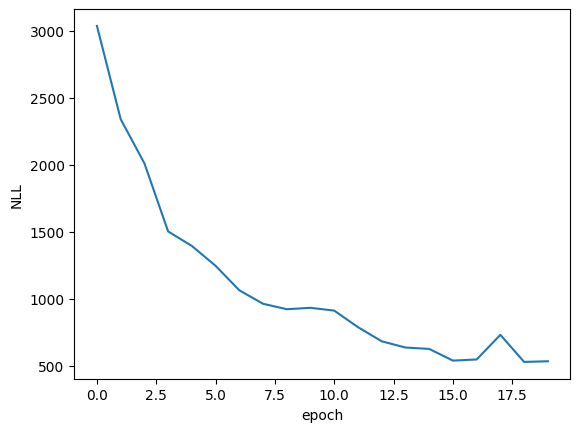

Training epoch 20


100%|██████████| 75/75 [00:13<00:00,  5.43batch/s, loss=919]    


- Log loss: 489.4749450683594
Training epoch 21


100%|██████████| 75/75 [00:13<00:00,  5.45batch/s, loss=998]    


- Log loss: 586.316162109375
Training epoch 22


100%|██████████| 75/75 [00:13<00:00,  5.39batch/s, loss=1.4e+3] 


- Log loss: 449.9901123046875
Training epoch 23


100%|██████████| 75/75 [00:13<00:00,  5.40batch/s, loss=1.07e+3]


- Log loss: 787.5053100585938
Training epoch 24


100%|██████████| 75/75 [00:14<00:00,  5.28batch/s, loss=1.18e+3]


- Log loss: 525.2718505859375
Training epoch 25


100%|██████████| 75/75 [00:14<00:00,  5.33batch/s, loss=1.2e+3] 


- Log loss: 426.6739807128906
Training epoch 26


100%|██████████| 75/75 [00:14<00:00,  5.28batch/s, loss=1.11e+3]


- Log loss: 411.563232421875
Training epoch 27


100%|██████████| 75/75 [00:13<00:00,  5.41batch/s, loss=1.34e+3]


- Log loss: 522.4010009765625
Training epoch 28


100%|██████████| 75/75 [00:14<00:00,  5.31batch/s, loss=1.18e+3]


- Log loss: 443.14300537109375
Training epoch 29


100%|██████████| 75/75 [00:14<00:00,  5.28batch/s, loss=1.18e+3]


- Log loss: 469.0675354003906
Training epoch 30


100%|██████████| 75/75 [00:14<00:00,  5.30batch/s, loss=1.47e+3]


- Log loss: 407.9255676269531
Training epoch 31


100%|██████████| 75/75 [00:14<00:00,  5.25batch/s, loss=1.22e+3]


- Log loss: 503.57550048828125
Training epoch 32


100%|██████████| 75/75 [00:14<00:00,  5.25batch/s, loss=1.06e+3]


- Log loss: 410.3403625488281
Training epoch 33


100%|██████████| 75/75 [00:14<00:00,  5.13batch/s, loss=846]    


- Log loss: 439.26763916015625
Training epoch 34


100%|██████████| 75/75 [00:14<00:00,  5.29batch/s, loss=1.13e+3]


- Log loss: 443.7095642089844
Training epoch 35


100%|██████████| 75/75 [00:14<00:00,  5.17batch/s, loss=1.12e+3]


- Log loss: 398.3719177246094
Training epoch 36


100%|██████████| 75/75 [00:14<00:00,  5.14batch/s, loss=787]    


- Log loss: 439.3850402832031
Training epoch 37


100%|██████████| 75/75 [00:14<00:00,  5.15batch/s, loss=1.58e+3]


- Log loss: 430.2427978515625
Training epoch 38


100%|██████████| 75/75 [00:14<00:00,  5.22batch/s, loss=799]    


- Log loss: 364.30059814453125
Training epoch 39


100%|██████████| 75/75 [00:14<00:00,  5.10batch/s, loss=1.01e+3]


- Log loss: 351.78271484375


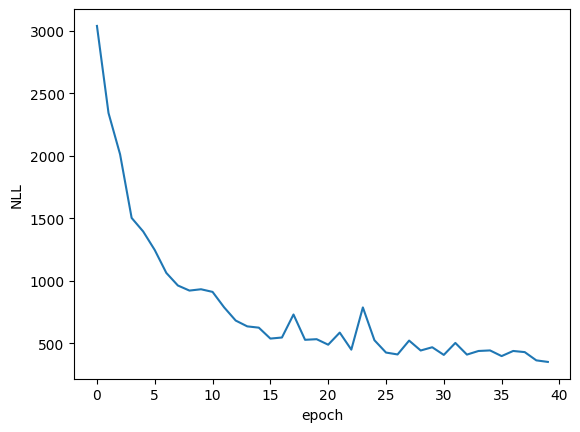

Training epoch 40


100%|██████████| 75/75 [00:14<00:00,  5.12batch/s, loss=1.18e+3]


- Log loss: 349.3407897949219
Training epoch 41


100%|██████████| 75/75 [00:14<00:00,  5.17batch/s, loss=511]    


- Log loss: 344.73828125
Training epoch 42


100%|██████████| 75/75 [00:14<00:00,  5.15batch/s, loss=681]    


- Log loss: 412.0405578613281
Training epoch 43


100%|██████████| 75/75 [00:14<00:00,  5.27batch/s, loss=1.1e+3] 


- Log loss: 348.1772766113281
Training epoch 44


100%|██████████| 75/75 [00:14<00:00,  5.01batch/s, loss=1.04e+3]


- Log loss: 438.08038330078125
Training epoch 45


100%|██████████| 75/75 [00:14<00:00,  5.21batch/s, loss=662]    


- Log loss: 328.26324462890625
Training epoch 46


100%|██████████| 75/75 [00:14<00:00,  5.04batch/s, loss=872]    


- Log loss: 404.52313232421875
Training epoch 47


100%|██████████| 75/75 [00:14<00:00,  5.18batch/s, loss=492]    


- Log loss: 359.3496398925781
Training epoch 48


100%|██████████| 75/75 [00:14<00:00,  5.09batch/s, loss=384]    


- Log loss: 363.1719665527344
Training epoch 49


100%|██████████| 75/75 [00:14<00:00,  5.15batch/s, loss=920]    


- Log loss: 342.8050537109375
Training epoch 50


100%|██████████| 75/75 [00:14<00:00,  5.09batch/s, loss=1.35e+3]


- Log loss: 320.3286437988281
Training epoch 51


100%|██████████| 75/75 [00:14<00:00,  5.20batch/s, loss=1.1e+3] 


- Log loss: 423.923828125
Training epoch 52


100%|██████████| 75/75 [00:14<00:00,  5.20batch/s, loss=1.3e+3] 


- Log loss: 438.8540954589844
Training epoch 53


100%|██████████| 75/75 [00:14<00:00,  5.17batch/s, loss=790]    


- Log loss: 369.14111328125
Training epoch 54


100%|██████████| 75/75 [00:14<00:00,  5.24batch/s, loss=638]    


- Log loss: 330.74237060546875
Training epoch 55


100%|██████████| 75/75 [00:14<00:00,  5.15batch/s, loss=476]    


- Log loss: 302.647705078125
Training epoch 56


100%|██████████| 75/75 [00:14<00:00,  5.26batch/s, loss=780]    


- Log loss: 421.5299987792969
Training epoch 57


100%|██████████| 75/75 [00:14<00:00,  5.08batch/s, loss=979]    


- Log loss: 344.1502380371094
Training epoch 58


100%|██████████| 75/75 [00:14<00:00,  5.23batch/s, loss=810]    


- Log loss: 366.2840576171875
Training epoch 59


100%|██████████| 75/75 [00:14<00:00,  5.24batch/s, loss=1.11e+3]


- Log loss: 311.447998046875


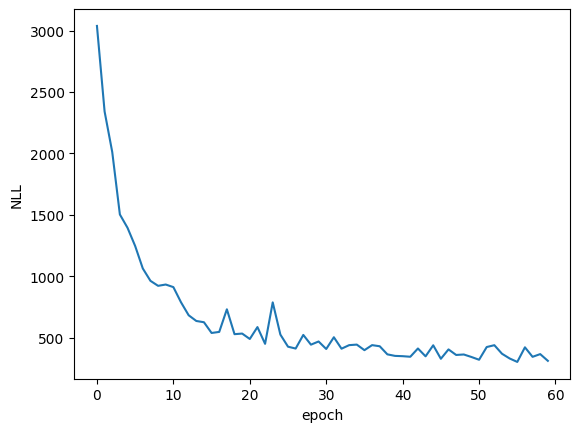

Training epoch 60


100%|██████████| 75/75 [00:14<00:00,  5.32batch/s, loss=882]    


- Log loss: 357.631103515625
Training epoch 61


100%|██████████| 75/75 [00:14<00:00,  5.29batch/s, loss=581]    


- Log loss: 310.1706237792969
Epoch 00062: reducing learning rate of group 0 to 5.0000e-05.
Training epoch 62


100%|██████████| 75/75 [00:14<00:00,  5.20batch/s, loss=822]    


- Log loss: 318.27911376953125
Training epoch 63


100%|██████████| 75/75 [00:14<00:00,  5.13batch/s, loss=554]    


- Log loss: 318.8573913574219
Training epoch 64


100%|██████████| 75/75 [00:14<00:00,  5.13batch/s, loss=615]    


- Log loss: 296.158935546875
Training epoch 65


100%|██████████| 75/75 [00:14<00:00,  5.34batch/s, loss=471]    


- Log loss: 316.678466796875
Training epoch 66


100%|██████████| 75/75 [00:14<00:00,  5.24batch/s, loss=657]    


- Log loss: 283.6885986328125
Training epoch 67


100%|██████████| 75/75 [00:14<00:00,  5.31batch/s, loss=558]    


- Log loss: 316.0011901855469
Training epoch 68


100%|██████████| 75/75 [00:14<00:00,  5.34batch/s, loss=679]    


- Log loss: 296.0931091308594
Training epoch 69


100%|██████████| 75/75 [00:14<00:00,  5.33batch/s, loss=1e+3]   


- Log loss: 311.3692626953125
Training epoch 70


100%|██████████| 75/75 [00:14<00:00,  5.34batch/s, loss=453]    


- Log loss: 308.4900817871094
Training epoch 71


100%|██████████| 75/75 [00:13<00:00,  5.38batch/s, loss=693]    


- Log loss: 296.95831298828125
Training epoch 72


100%|██████████| 75/75 [00:13<00:00,  5.40batch/s, loss=700]    


- Log loss: 293.40643310546875
Epoch 00073: reducing learning rate of group 0 to 2.5000e-05.
Training epoch 73


100%|██████████| 75/75 [00:14<00:00,  5.34batch/s, loss=490]    


- Log loss: 299.794677734375
Training epoch 74


100%|██████████| 75/75 [00:14<00:00,  5.28batch/s, loss=586]    


- Log loss: 294.0357971191406
Training epoch 75


100%|██████████| 75/75 [00:14<00:00,  5.25batch/s, loss=785]    


- Log loss: 277.080810546875
Training epoch 76


100%|██████████| 75/75 [00:14<00:00,  5.26batch/s, loss=344]    


- Log loss: 298.380126953125
Training epoch 77


100%|██████████| 75/75 [00:13<00:00,  5.46batch/s, loss=480]    


- Log loss: 300.2822265625
Training epoch 78


100%|██████████| 75/75 [00:13<00:00,  5.42batch/s, loss=876]    


- Log loss: 304.39849853515625
Training epoch 79


100%|██████████| 75/75 [00:13<00:00,  5.44batch/s, loss=654]    


- Log loss: 295.740966796875


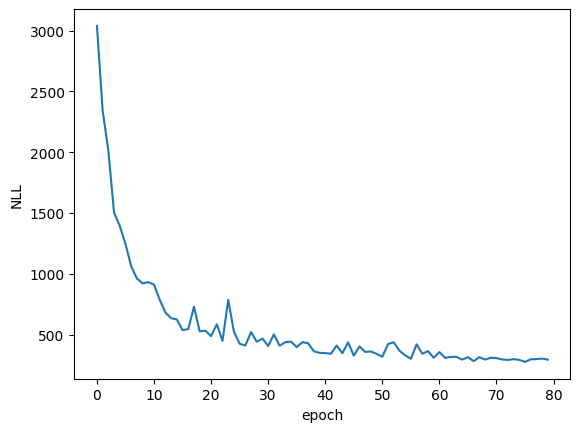

Training epoch 80


100%|██████████| 75/75 [00:14<00:00,  5.25batch/s, loss=395]    


- Log loss: 309.3096008300781
Training epoch 81


100%|██████████| 75/75 [00:14<00:00,  5.35batch/s, loss=462]    


- Log loss: 313.3468322753906
Epoch 00082: reducing learning rate of group 0 to 1.2500e-05.
Training epoch 82


100%|██████████| 75/75 [00:14<00:00,  5.35batch/s, loss=791]    


- Log loss: 295.2287902832031
Training epoch 83


100%|██████████| 75/75 [00:13<00:00,  5.45batch/s, loss=613]    


- Log loss: 282.38250732421875
Training epoch 84


100%|██████████| 75/75 [00:14<00:00,  5.29batch/s, loss=492]    


- Log loss: 283.19219970703125
Training epoch 85


100%|██████████| 75/75 [00:13<00:00,  5.46batch/s, loss=299]    


- Log loss: 278.0069580078125
Training epoch 86


100%|██████████| 75/75 [00:13<00:00,  5.40batch/s, loss=404]    


- Log loss: 273.6505126953125
Training epoch 87


100%|██████████| 75/75 [00:14<00:00,  5.28batch/s, loss=586]    


- Log loss: 280.77764892578125
Training epoch 88


100%|██████████| 75/75 [00:13<00:00,  5.44batch/s, loss=694]    


- Log loss: 276.7014465332031
Training epoch 89


100%|██████████| 75/75 [00:14<00:00,  5.35batch/s, loss=380]    


- Log loss: 263.8938293457031
Training epoch 90


100%|██████████| 75/75 [00:13<00:00,  5.46batch/s, loss=507]    


- Log loss: 258.9709777832031
Training epoch 91


100%|██████████| 75/75 [00:13<00:00,  5.41batch/s, loss=614]    


- Log loss: 280.95233154296875
Training epoch 92


100%|██████████| 75/75 [00:13<00:00,  5.45batch/s, loss=613]    


- Log loss: 270.7180480957031
Training epoch 93


100%|██████████| 75/75 [00:13<00:00,  5.42batch/s, loss=428]    


- Log loss: 282.759765625
Training epoch 94


100%|██████████| 75/75 [00:13<00:00,  5.38batch/s, loss=638]    


- Log loss: 294.9898681640625
Training epoch 95


100%|██████████| 75/75 [00:13<00:00,  5.50batch/s, loss=391]    


- Log loss: 291.0806579589844
Training epoch 96


100%|██████████| 75/75 [00:13<00:00,  5.38batch/s, loss=687]    


- Log loss: 300.6800231933594
Epoch 00097: reducing learning rate of group 0 to 6.2500e-06.
Training epoch 97


100%|██████████| 75/75 [00:13<00:00,  5.46batch/s, loss=414]    


- Log loss: 275.6306457519531
Training epoch 98


100%|██████████| 75/75 [00:13<00:00,  5.38batch/s, loss=287]    


- Log loss: 286.6892395019531
Training epoch 99


100%|██████████| 75/75 [00:13<00:00,  5.47batch/s, loss=978]    


- Log loss: 275.2315673828125


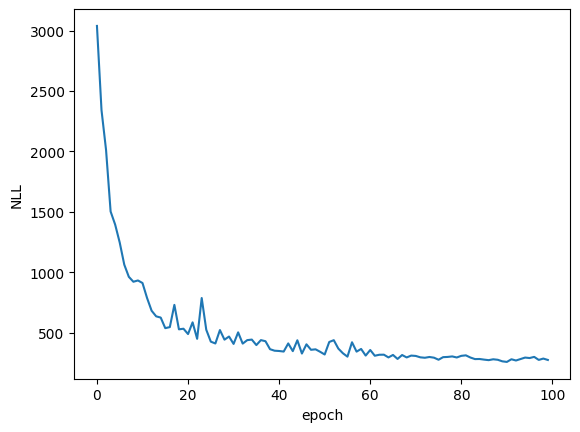

Training epoch 100


100%|██████████| 75/75 [00:13<00:00,  5.46batch/s, loss=535]   


- Log loss: 282.3258972167969
Training epoch 101


100%|██████████| 75/75 [00:13<00:00,  5.37batch/s, loss=296]


- Log loss: 258.54681396484375
Training epoch 102


100%|██████████| 75/75 [00:13<00:00,  5.49batch/s, loss=893]    


- Log loss: 271.05291748046875
Training epoch 103


100%|██████████| 75/75 [00:14<00:00,  5.30batch/s, loss=934]    


- Log loss: 270.8445129394531
Training epoch 104


100%|██████████| 75/75 [00:13<00:00,  5.46batch/s, loss=684]


- Log loss: 266.2021789550781
Training epoch 105


100%|██████████| 75/75 [00:14<00:00,  5.36batch/s, loss=415]    


- Log loss: 260.90521240234375
Training epoch 106


100%|██████████| 75/75 [00:13<00:00,  5.41batch/s, loss=469]    


- Log loss: 296.1213073730469
Training epoch 107


100%|██████████| 75/75 [00:13<00:00,  5.48batch/s, loss=350]    


- Log loss: 257.2228698730469
Training epoch 108


100%|██████████| 75/75 [00:14<00:00,  5.33batch/s, loss=657]    


- Log loss: 265.8484191894531
Training epoch 109


100%|██████████| 75/75 [00:13<00:00,  5.37batch/s, loss=453]    


- Log loss: 270.3686218261719
Training epoch 110


100%|██████████| 75/75 [00:14<00:00,  5.28batch/s, loss=899]    


- Log loss: 262.3134460449219
Training epoch 111


100%|██████████| 75/75 [00:13<00:00,  5.40batch/s, loss=495]    


- Log loss: 280.19427490234375
Training epoch 112


100%|██████████| 75/75 [00:14<00:00,  5.29batch/s, loss=469]    


- Log loss: 266.3733215332031
Training epoch 113


100%|██████████| 75/75 [00:13<00:00,  5.36batch/s, loss=388]    


- Log loss: 278.0558166503906
Epoch 00114: reducing learning rate of group 0 to 3.1250e-06.
Training epoch 114


100%|██████████| 75/75 [00:14<00:00,  5.35batch/s, loss=507]


- Log loss: 273.6650085449219
Training epoch 115


100%|██████████| 75/75 [00:13<00:00,  5.41batch/s, loss=524]    


- Log loss: 273.364501953125
Training epoch 116


100%|██████████| 75/75 [00:13<00:00,  5.40batch/s, loss=642]   


- Log loss: 271.7242431640625
Training epoch 117


100%|██████████| 75/75 [00:14<00:00,  5.29batch/s, loss=647]    


- Log loss: 260.6003112792969
Training epoch 118


100%|██████████| 75/75 [00:13<00:00,  5.43batch/s, loss=544]    


- Log loss: 268.0349426269531
Training epoch 119


100%|██████████| 75/75 [00:14<00:00,  5.35batch/s, loss=605]    


- Log loss: 274.21319580078125
Epoch 00120: reducing learning rate of group 0 to 1.5625e-06.


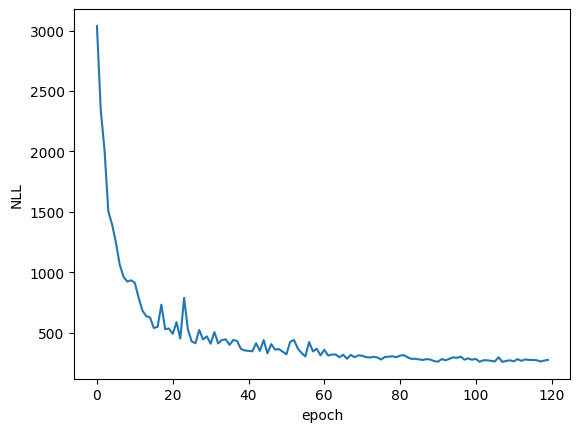

Training epoch 120


100%|██████████| 75/75 [00:13<00:00,  5.45batch/s, loss=614]    


- Log loss: 268.6662292480469
Training epoch 121


100%|██████████| 75/75 [00:13<00:00,  5.37batch/s, loss=461]   


- Log loss: 269.2594299316406
Training epoch 122


100%|██████████| 75/75 [00:13<00:00,  5.39batch/s, loss=812]    


- Log loss: 264.2001953125
Training epoch 123


100%|██████████| 75/75 [00:13<00:00,  5.43batch/s, loss=415]    


- Log loss: 268.4578552246094
Training epoch 124


100%|██████████| 75/75 [00:13<00:00,  5.39batch/s, loss=834]    


- Log loss: 257.79541015625
Training epoch 125


100%|██████████| 75/75 [00:13<00:00,  5.45batch/s, loss=690]    


- Log loss: 262.35150146484375
Epoch 00126: reducing learning rate of group 0 to 7.8125e-07.
Training epoch 126


100%|██████████| 75/75 [00:14<00:00,  5.24batch/s, loss=442]    


- Log loss: 265.10638427734375
Training epoch 127


100%|██████████| 75/75 [00:13<00:00,  5.42batch/s, loss=533]    


- Log loss: 271.24993896484375
Training epoch 128


100%|██████████| 75/75 [00:13<00:00,  5.38batch/s, loss=319]    


- Log loss: 258.3621826171875
Training epoch 129


100%|██████████| 75/75 [00:13<00:00,  5.42batch/s, loss=1.13e+3]


- Log loss: 260.7063293457031
Training epoch 130


100%|██████████| 75/75 [00:13<00:00,  5.45batch/s, loss=482]


- Log loss: 267.09222412109375
Training epoch 131


100%|██████████| 75/75 [00:13<00:00,  5.38batch/s, loss=525]    


- Log loss: 266.317626953125
Epoch 00132: reducing learning rate of group 0 to 3.9063e-07.
Training epoch 132


100%|██████████| 75/75 [00:13<00:00,  5.39batch/s, loss=595]


- Log loss: 266.9442443847656
Training epoch 133


100%|██████████| 75/75 [00:14<00:00,  5.29batch/s, loss=728]    


- Log loss: 270.1007385253906
Training epoch 134


100%|██████████| 75/75 [00:13<00:00,  5.45batch/s, loss=577]    


- Log loss: 263.1023254394531
Training epoch 135


100%|██████████| 75/75 [00:13<00:00,  5.39batch/s, loss=348]   


- Log loss: 267.6445007324219
Training epoch 136


100%|██████████| 75/75 [00:13<00:00,  5.46batch/s, loss=599]    


- Log loss: 273.23931884765625
Training epoch 137


100%|██████████| 75/75 [00:13<00:00,  5.42batch/s, loss=478]    


- Log loss: 266.8892517089844
Epoch 00138: reducing learning rate of group 0 to 1.9531e-07.
Training epoch 138


100%|██████████| 75/75 [00:13<00:00,  5.38batch/s, loss=617]


- Log loss: 267.6350402832031
Training epoch 139


100%|██████████| 75/75 [00:13<00:00,  5.42batch/s, loss=368]    


- Log loss: 269.5047912597656


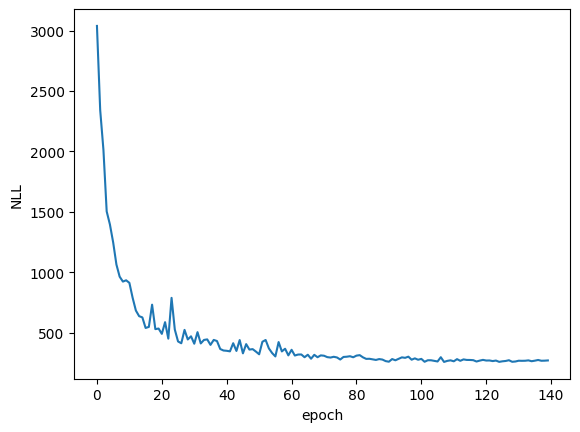

Training epoch 140


100%|██████████| 75/75 [00:14<00:00,  5.34batch/s, loss=578]    


- Log loss: 263.38287353515625
Training epoch 141


100%|██████████| 75/75 [00:13<00:00,  5.42batch/s, loss=655]


- Log loss: 262.18475341796875
Training epoch 142


100%|██████████| 75/75 [00:14<00:00,  5.32batch/s, loss=909]    


- Log loss: 264.25311279296875
Training epoch 143


  9%|▉         | 7/75 [00:01<00:14,  4.77batch/s, loss=511]


KeyboardInterrupt: 

In [40]:
# from models import *
# from trainer import *
# from loader import *
from torch.distributions.bernoulli import Bernoulli
from torch.distributions.multivariate_normal import MultivariateNormal
import sys

from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
from torch.nn import DataParallel

#python3 train.py 12 FINAL_12/

# Input arguments
# channels = int(sys.argv[1])
# out_dir = sys.argv[2]

channels = 12
out_dir = '/kaggle/working/train_out/'

# Set up 
torch.manual_seed(0)
torch.backends.cudnn.benchmark = True
device = torch.device('cuda')

# Set up model
# model = UNet_Attention(img_ch=channels,
#             output_ch=1,
#             )
model = Unet(in_channels=channels,
            out_channels=1,
            div_factor=1, 
            prob_output=False)
model = model.to(device)
model = nn.DataParallel(model)

# Set up loss function
loss_fn = loss

train_dataset = MethaneLoader(device = "cuda", mode="train", plume_id=None, channels=channels)
test_dataset = MethaneLoader(device = "cuda", mode="test", plume_id=None, channels=channels)

#print(train_dataset.__len__())

train_loader = DataLoader(train_dataset, 
                          batch_size = 16, 
                          shuffle = True)

test_loader = DataLoader(test_dataset, 
                          batch_size = 16, 
                          shuffle = True)


# Make the trainer
trainer = Trainer(model,
                  train_loader,
                  test_loader,
                  train_dataset,
                  loss_fn,
                  out_dir,
                  1e-4)

# Train
trainer.train(n_epochs=300)

In [ ]:
### for clearing directory
### skip it
#!rm -rf /kaggle/working/*

In [41]:
def visualize(idx):
    file_paths = glob('/kaggle/input/ch4net-dataset/data/val/mbmp/*/{}.npy'.format(idx))
    for file in file_paths:
        category = file.split("/")[-2]
        print(category)
        image1 = np.load(file)
    image2 = np.load("/kaggle/working/eval_out/target_{}.npy".format(idx))
    image3 = np.load("/kaggle/working/eval_out/out_{}.npy".format(idx))

    # Squeeze the extra dimension if needed
    image1 = np.squeeze(image1)
    image2 = np.squeeze(image2)
    image3 = np.squeeze(image3)

    print(image1.shape, image2.shape, image3.shape)

    # Create a figure with 3 subplots side by side
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    # Display each image
    axes[0].imshow(image1, cmap='magma')
    axes[0].set_title('MBMP')
    axes[0].axis('off')  # Hide axis

    axes[1].imshow(image2, cmap='magma')
    axes[1].set_title('Target')
    axes[1].axis('off')  # Hide axis

    axes[2].imshow(image3, cmap='magma')
    axes[2].set_title('Out')
    axes[2].axis('off')  # Hide axis

    # Show the figure
    plt.tight_layout()
    plt.show()

In [42]:
from matplotlib import pyplot as plt
import torch
import numpy as np
from tqdm import tqdm

# from models import *
# from trainer import *
# from loader import *

from torch.utils.data import DataLoader
from glob import glob

# python3 gen_eval_preds.py 12 final_12_all/ final_12_preds/ 0
# in_dir = sys.argv[2]
# out_dir = sys.argv[3]
# channels = int(sys.argv[1])
# alli_yn = bool(int(sys.argv[4]))

in_dir = "/kaggle/working/train_out/"
out_dir = "/kaggle/working/eval_out/"
channels = 12
alli_yn = False

print("Loading losses...")
losses = np.load(in_dir+"losses.npy")
best_epoch = np.argmin(losses)
print('best epoch: ', best_epoch)

device = torch.device('cuda')

# Set up model
# model = UNet_Attention(img_ch=channels,
#             output_ch=1,
#             )
model = Unet(in_channels=channels,
            out_channels=1,
            div_factor=1, 
            prob_output=False)
model = model.to(device)
model = nn.DataParallel(model)

model.load_state_dict(torch.load(in_dir+"final_model",
                      map_location=torch.device('cuda'))["model_state_dict"])
# model.load_state_dict(torch.load('/kaggle/input/ch4net_attention/pytorch/default/1/final_model',
#                       map_location=torch.device('cuda'))["model_state_dict"])
model.eval()
print()

Loading losses...
best epoch:  107



In [43]:
import torch
import numpy as np

def calculate_iou(pred, target):
    """
    Calculate Intersection over Union (IoU)
    """
    pred = pred > 0  # Convert to binary mask
    target = target > 0  # Convert to binary mask
    intersection = np.logical_and(target, pred)
    union = np.logical_or(target, pred)
    iou_score = np.sum(intersection) / np.sum(union)
    return iou_score

def calculate_accuracy(pred, target):
    """
    Calculate pixel-wise accuracy
    """
    pred = pred > 0  # Convert to binary mask
    target = target > 0  # Convert to binary mask
    correct = np.sum(pred == target)
    total = pred.size
    return correct / total

In [44]:
import torch
import torch.nn.functional as F
import numpy as np
from sklearn.metrics import balanced_accuracy_score

def calculate_metrics(pred, target, epsilon=1e-6):
    """
    Calculate IoU, Accuracy, Recall, Balanced Accuracy, False Positive Rate, and False Negative Rate
    """
    pred = F.sigmoid(torch.tensor(pred)).numpy()
    pred = pred > 0.5 # Convert to binary mask
    target = target > 0  # Convert to binary mask
    
    true_positive = np.sum(np.logical_and(pred, target))
    false_positive = np.sum(np.logical_and(pred, np.logical_not(target)))
    false_negative = np.sum(np.logical_and(np.logical_not(pred), target))
    true_negative = np.sum(np.logical_and(np.logical_not(pred), np.logical_not(target)))
    
    # IoU
    union = np.sum(np.logical_or(pred, target))
    iou = (true_positive + epsilon) / (union + epsilon)
    
    # Accuracy
    total = pred.size
    accuracy = (true_positive + true_negative) / total
    
    # Recall (True Positive Rate)
    recall = (true_positive + epsilon) / (true_positive + false_negative + epsilon)
    
    # False Positive Rate
    fpr = (false_positive + epsilon) / (false_positive + true_negative + epsilon)
    
    # False Negative Rate
    fnr = (false_negative + epsilon) / (false_negative + true_positive + epsilon)
    
    # Balanced Accuracy
#     balanced_acc = balanced_accuracy_score(target.flatten(), pred.flatten())
    balanced_acc = None
    
    return iou, accuracy, recall, balanced_acc, fpr, fnr

# ... [Previous imports and setup code remains the same]

losses = []
ious = []
accuracies = []
recalls = []
balanced_accs = []
fprs = []
fnrs = []

# Iterate over each plume
for i in tqdm(range(250)):
    preds = []
    targets = []

    test_dataset = MethaneLoader(
        device="cuda", mode="val", alli=alli_yn, plume_id=i, channels=channels)

    val_loader = DataLoader(test_dataset,
                            batch_size=64,
                            shuffle=False)

    for batch in val_loader:
        out = model(batch["pred"])
        preds.append(np.squeeze(out).cpu())
        targets.append(np.squeeze(batch["target"]).cpu())
        loss_val = loss_fn(np.squeeze(out), np.squeeze(batch["target"]))
        losses.append(loss_val.item())
        
    if len(preds) > 0:
        preds = torch.concat(preds, dim=0).detach().numpy()
        targets = torch.concat(targets, dim=0).detach().numpy()

        # Calculate metrics for this plume
        iou, accuracy, recall, balanced_acc, fpr, fnr = calculate_metrics(preds, targets)
        
        ious.append(iou)
        accuracies.append(accuracy)
        recalls.append(recall)
        balanced_accs.append(balanced_acc)
        fprs.append(fpr)
        fnrs.append(fnr)
        
        preds = F.sigmoid(torch.tensor(preds)).numpy()
        preds = preds > 0.5 # Convert to binary mask
        np.save(out_dir+f"out_{i}.npy", preds)
        np.save(out_dir+f"target_{i}.npy", targets)

# Calculate and print overall metrics
mean_loss = np.mean(losses)
mean_iou = np.mean(ious)
mean_accuracy = np.mean(accuracies)
mean_recall = np.mean(recalls)
# mean_balanced_acc = np.mean(balanced_accs)
mean_fpr = np.mean(fprs)
mean_fnr = np.mean(fnrs)

print(f"Mean Loss: {mean_loss:.4f}")
print(f"Mean IoU: {mean_iou:.4f}")
print(f"Mean Accuracy: {mean_accuracy:.4f}")
print(f"Mean Recall: {mean_recall:.4f}")
# print(f"Mean Balanced Accuracy: {mean_balanced_acc:.4f}")
print(f"Mean False Positive Rate: {mean_fpr:.4f}")
print(f"Mean False Negative Rate: {mean_fnr:.4f}")

# Save metrics
np.save(out_dir+"metrics.npy", {
    "loss": mean_loss,
    "iou": mean_iou,
    "accuracy": mean_accuracy,
    "recall": mean_recall,
#     "balanced_accuracy": mean_balanced_acc,
    "false_positive_rate": mean_fpr,
    "false_negative_rate": mean_fnr
})

100%|██████████| 250/250 [00:11<00:00, 22.22it/s]

Mean Loss: 900.6432
Mean IoU: 0.5955
Mean Accuracy: 0.9857
Mean Recall: 0.6556
Mean False Positive Rate: 0.0020
Mean False Negative Rate: 0.8585


pos
1779.7061767578125


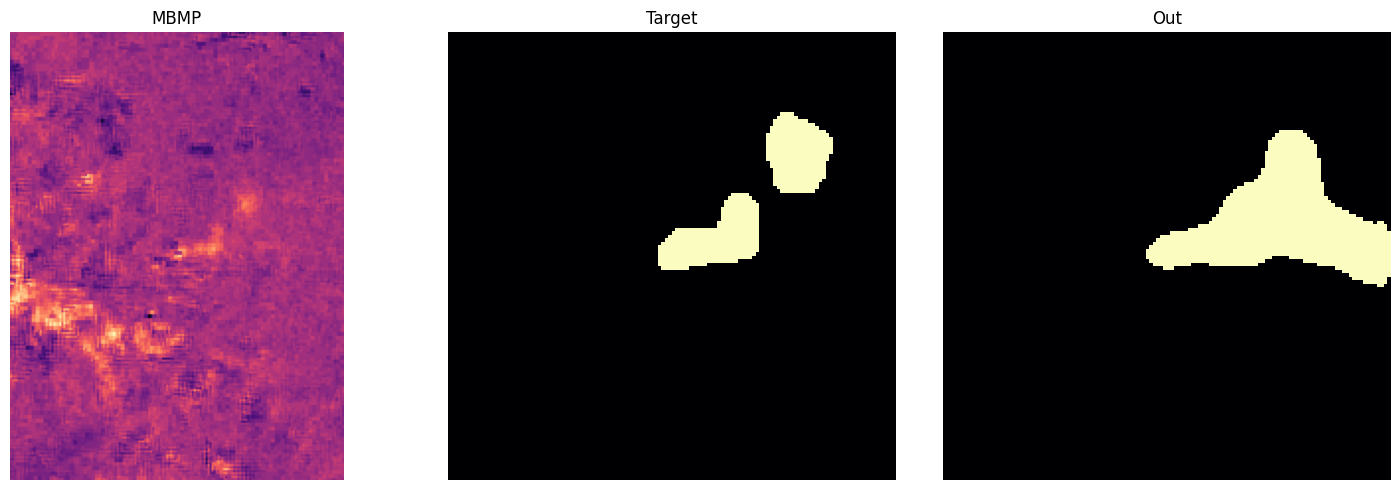

neg
217.83468627929688


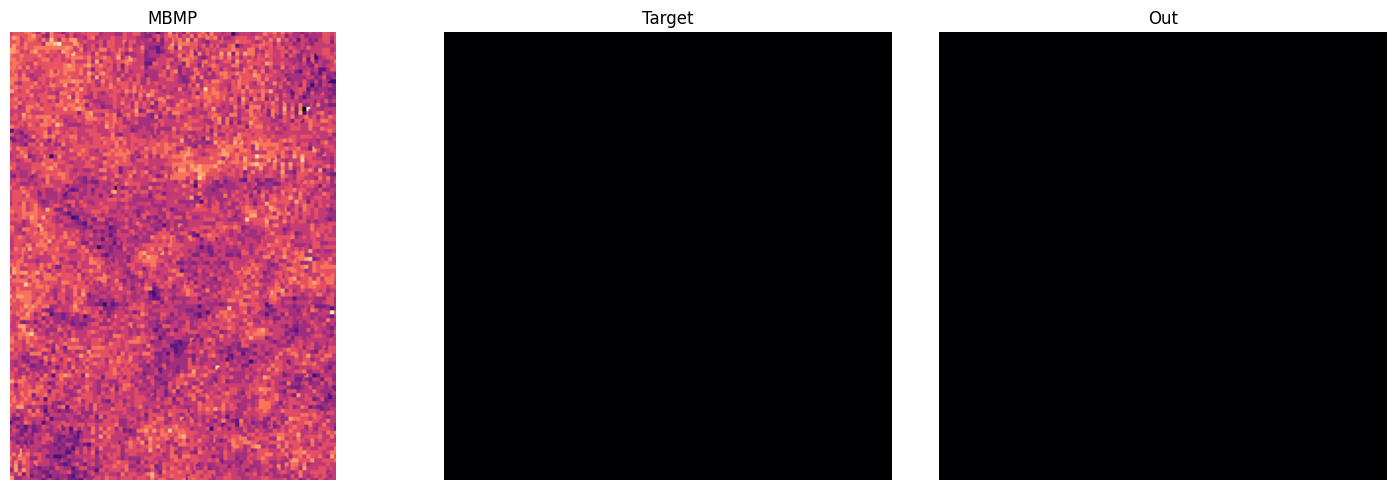

neg
1021.497314453125


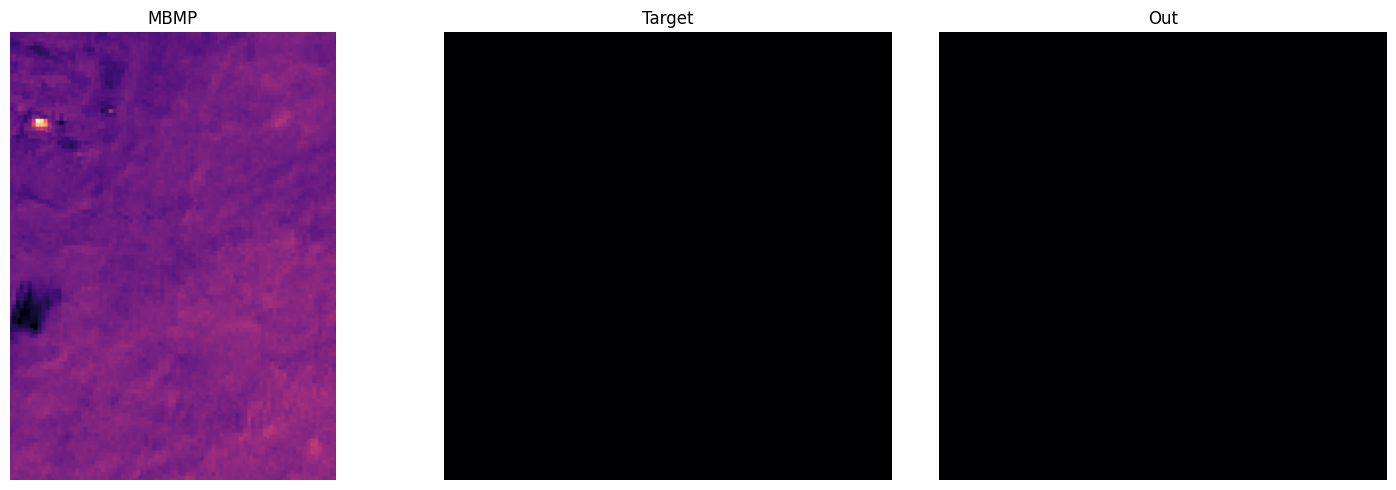

pos
909.4105224609375


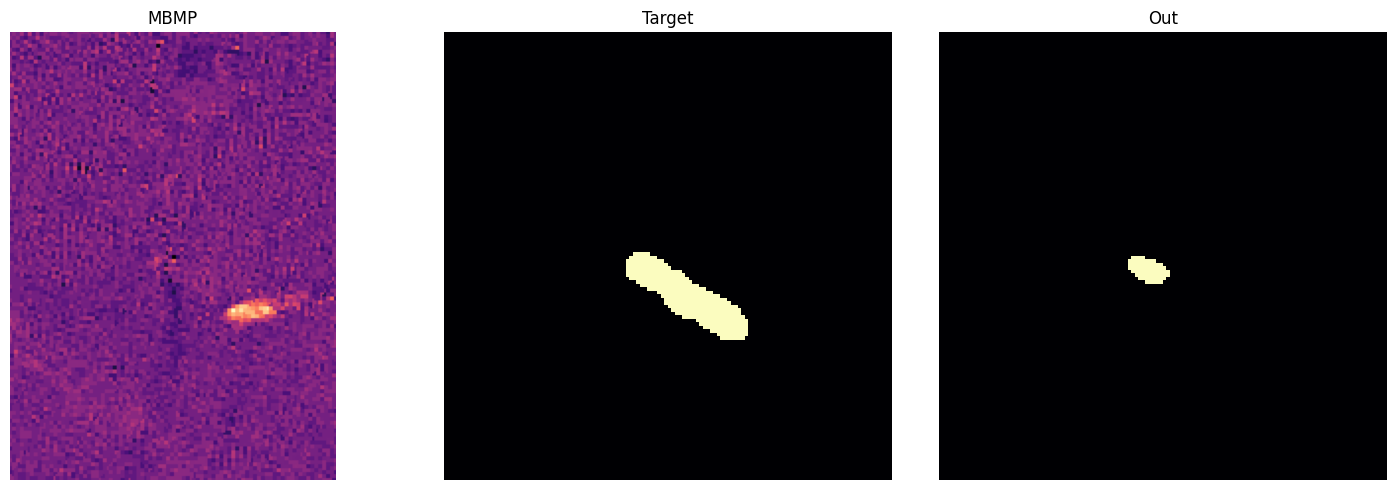

pos
898.3695678710938


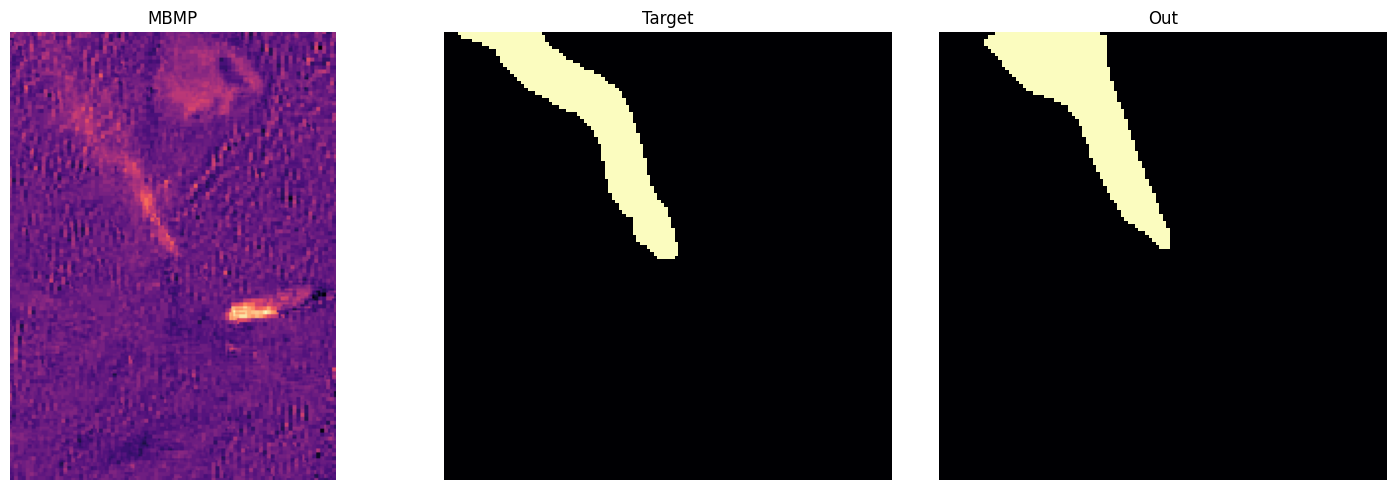

pos
1012.6593017578125


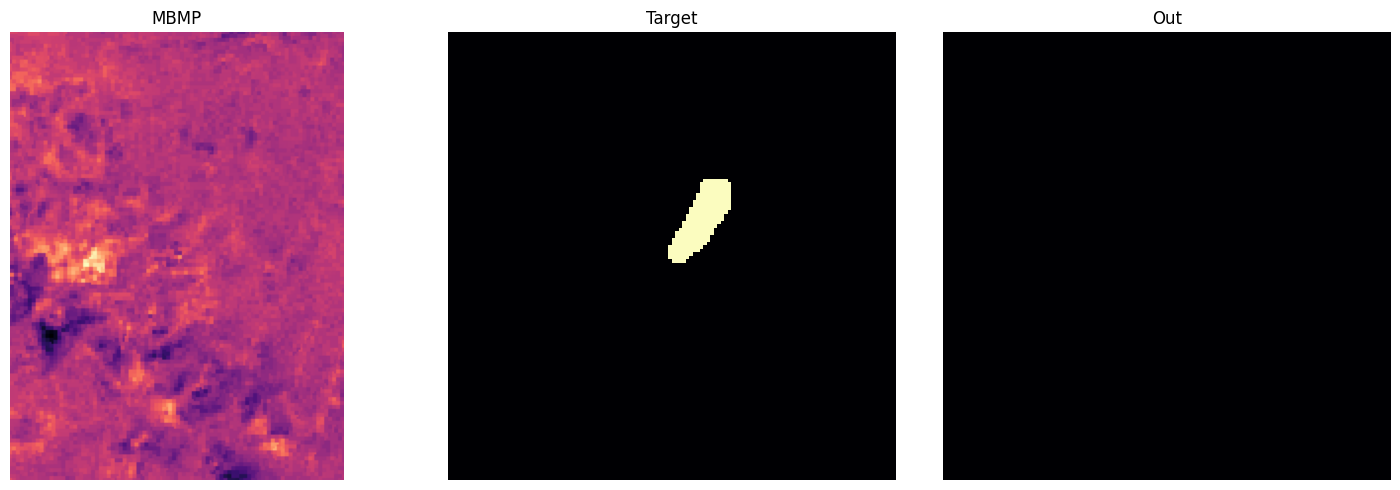

neg
151.23069763183594


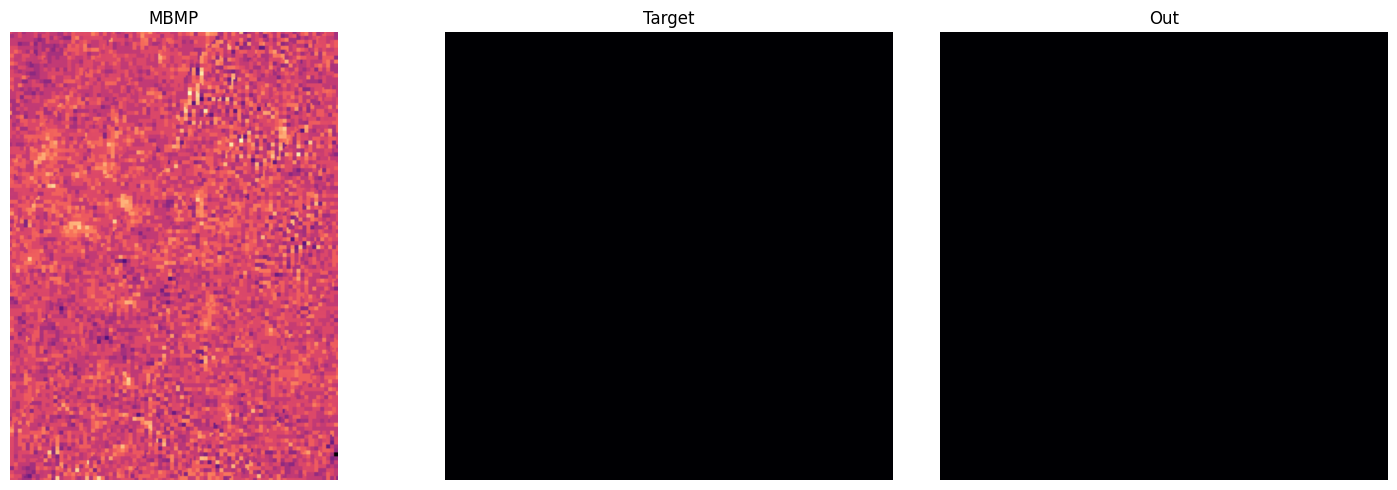

pos
1031.32470703125


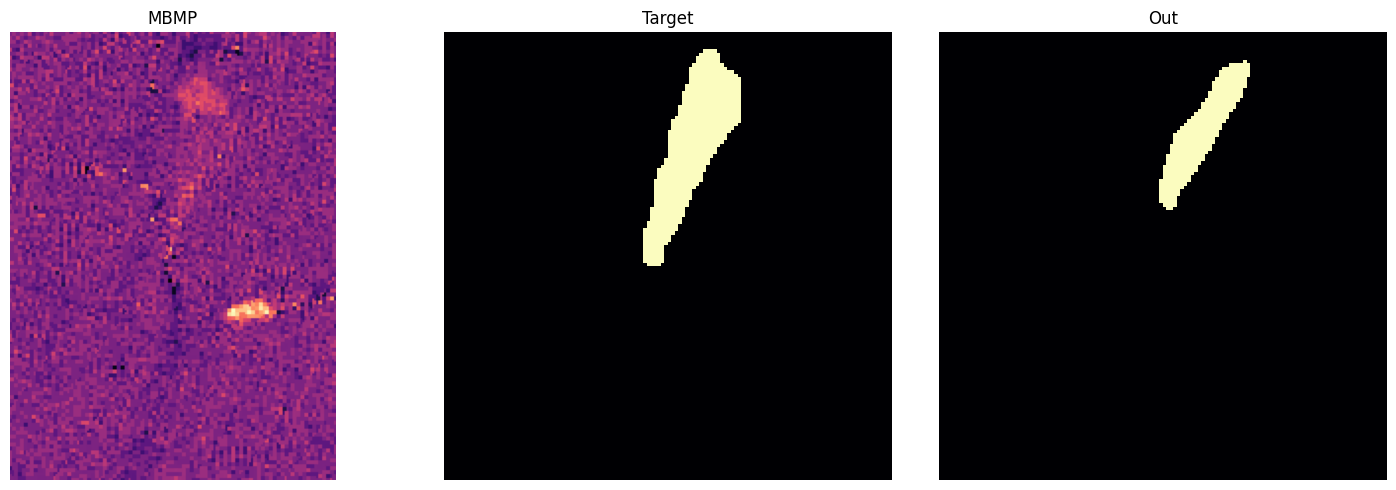

pos
14.174155235290527


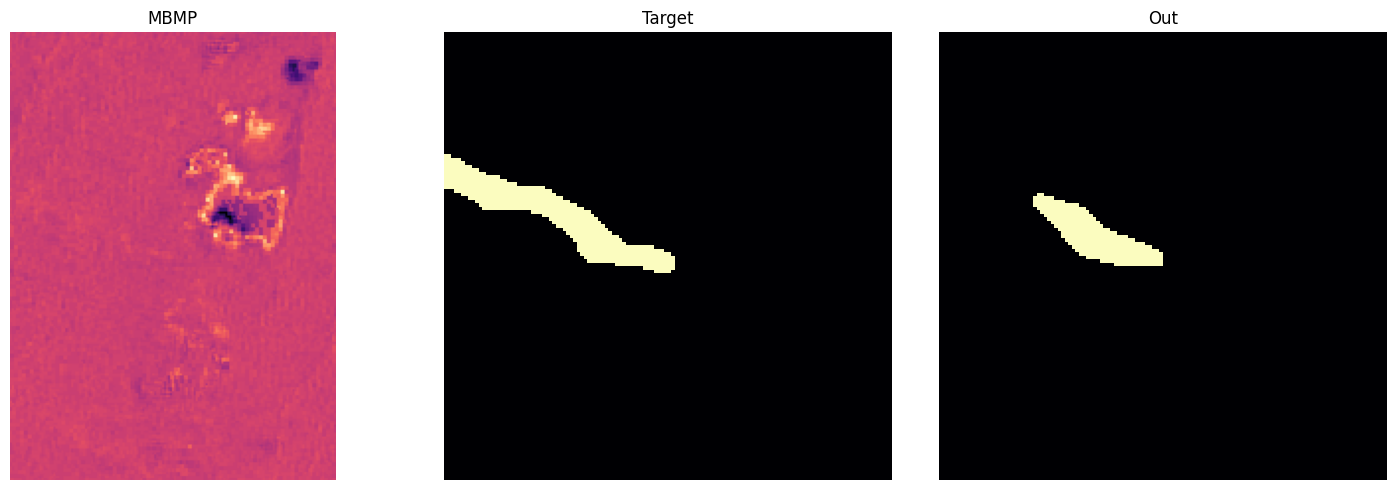

neg
16.661211013793945


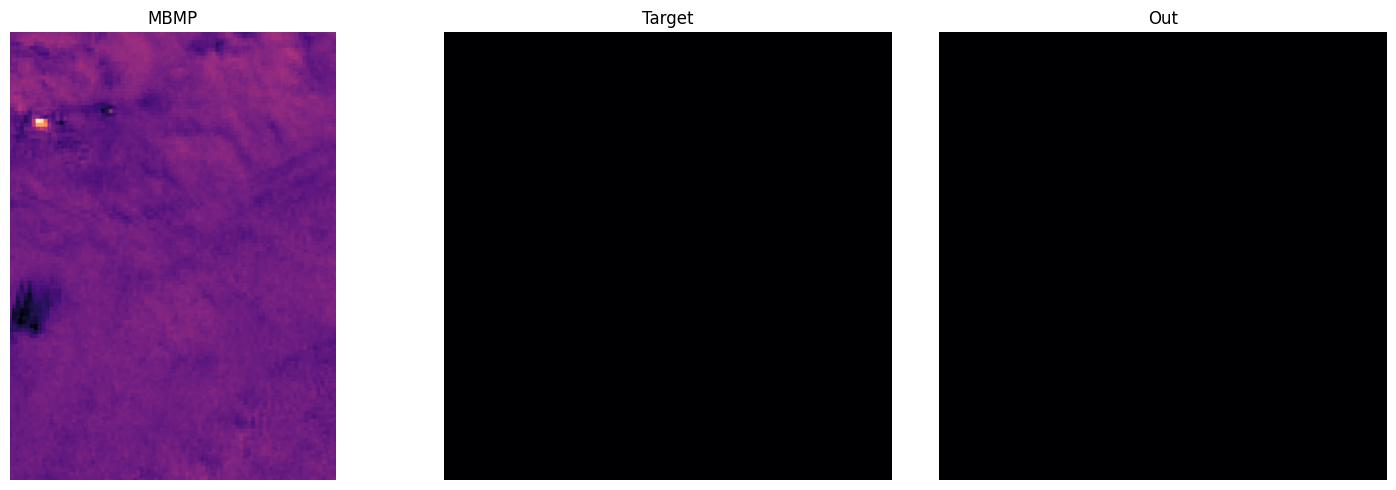

In [45]:
# from glob import glob

# visualize masks
samples = 250

# def visualize(idx):
    
for i in range(samples):
    idx = np.random.randint(0, samples)
#     idx = i

    file_paths = glob('/kaggle/input/ch4net-dataset/data/val/mbmp/*/{}.npy'.format(idx))
    for file in file_paths:
        category = file.split("/")[-2]
        print(category)
        image1 = np.load(file)
    image2 = np.load("/kaggle/working/eval_out/target_{}.npy".format(idx))
    image3 = np.load("/kaggle/working/eval_out/out_{}.npy".format(idx))

    # Squeeze the extra dimension if needed
    image1 = np.squeeze(image1)
    image2 = np.squeeze(image2)
    image3 = np.squeeze(image3)

#     print(image1.shape, image2.shape, image3.shape)
    print(losses[idx])

    # Create a figure with 3 subplots side by side
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    # Display each image
    axes[0].imshow(image1, cmap='magma')
    axes[0].set_title('MBMP')
    axes[0].axis('off')  # Hide axis

    axes[1].imshow(image2, cmap='magma')
    axes[1].set_title('Target')
    axes[1].axis('off')  # Hide axis

    axes[2].imshow(image3, cmap='magma')
    axes[2].set_title('Out')
    axes[2].axis('off')  # Hide axis

    # Show the figure
    plt.tight_layout()
    plt.show()
    
    i = i + 1
    if(i==10): break
